### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

# Clase 1: rho1, etiqueta = 1
a_test = np.random.uniform(0, 1, int(n_test/2))
for a in a_test:
    rho, label = ρ1(a)
    data_test.append((rho, label))

# Clase 2: rho2, etiqueta = 2
b_test = np.random.uniform(0, 1, int(n_test/2))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 50
data = []

# Familia 1 → usa ρ1(a), etiqueta = 1
a_values = np.random.uniform(0, 1, int(n_samples/2))
for a in a_values:
    rho, label = ρ1(a)  # rho es matriz 4x4, label = 1
    data.append((rho, label))

# Familia 2 → usa ρ2(b), etiqueta = 2
b_values = np.random.uniform(0, 1, int(n_samples/2))
for b in b_values:
    rho, label = ρ2(b)  # rho es matriz 4x4, label = 2
    data.append((rho, label))

# Mezclar y dividir: 80% entrenamiento, 20% validación
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 25  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 1000
batch_size = int(len(data_train)*0.2)
val_batch_size=int(0.2*batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 100
min_delta = 1e-6
best_val_loss = float('inf')
patience_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
test_suc_history = []
test_err_history = []
test_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):
    
    # Seleccionar un batch aleatorio de data_train
    batch = random.sample(data_train, batch_size)
    
    # Paso de entrenamiento con el batch
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)
    
    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)




    # Early stopping
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"⏹️ Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        break

    # Evaluación en train y test
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_test, err_test, inc_test = evaluate_model(params, data_test)

    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    test_suc_history.append(suc_test)
    test_err_history.append(err_test)
    test_inc_history.append(inc_test)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"test_suc={suc_test:.3f}, test_err={err_test:.3f}, test_inc={inc_test:.3f}")

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
print(f"  Éxito promedio     = {suc_test:.4f}")
print(f"  Error promedio     = {err_test:.4f}")
print(f"  Inconcluso promedio = {inc_test:.4f}")




Entrenando:   0%|          | 0/1000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/1000 [07:02<117:14:30, 422.49s/it]

Entrenando:   0%|          | 2/1000 [14:03<116:57:05, 421.87s/it]

Entrenando:   0%|          | 3/1000 [21:06<116:51:51, 421.98s/it]

Entrenando:   0%|          | 4/1000 [28:06<116:37:46, 421.55s/it]

Entrenando:   0%|          | 5/1000 [35:10<116:44:31, 422.38s/it]

Entrenando:   1%|          | 6/1000 [42:14<116:45:08, 422.85s/it]

Entrenando:   1%|          | 7/1000 [49:22<117:07:13, 424.61s/it]

Entrenando:   1%|          | 8/1000 [56:28<117:04:06, 424.85s/it]

Entrenando:   1%|          | 9/1000 [1:03:29<116:41:33, 423.91s/it]

Entrenando:   1%|          | 10/1000 [1:10:35<116:44:51, 424.54s/it]

Entrenando:   1%|          | 11/1000 [1:17:42<116:47:49, 425.15s/it]

Entrenando:   1%|          | 12/1000 [1:24:48<116:46:31, 425.50s/it]

Entrenando:   1%|▏         | 13/1000 [1:31:56<116:48:15, 426.03s/it]

Entrenando:   1%|▏         | 14/1000 [1:39:01<116:37:04, 425.79s/it]

Entrenando:   2%|▏         | 15/1000 [1:46:02<116:06:24, 424.35s/it]

Entrenando:   2%|▏         | 16/1000 [1:53:07<116:05:23, 424.72s/it]

Entrenando:   2%|▏         | 17/1000 [2:00:15<116:10:48, 425.48s/it]

Entrenando:   2%|▏         | 18/1000 [2:07:19<115:56:30, 425.04s/it]

Entrenando:   2%|▏         | 19/1000 [2:14:24<115:50:57, 425.13s/it]

Entrenando:   2%|▏         | 20/1000 [2:21:25<115:25:49, 424.03s/it]

Entrenando:   2%|▏         | 21/1000 [2:28:28<115:12:51, 423.67s/it]

Entrenando:   2%|▏         | 22/1000 [2:35:31<114:59:29, 423.28s/it]

Entrenando:   2%|▏         | 23/1000 [2:42:32<114:44:19, 422.78s/it]

Entrenando:   2%|▏         | 24/1000 [2:49:34<114:32:58, 422.52s/it]

Entrenando:   2%|▎         | 25/1000 [2:56:39<114:36:32, 423.17s/it]

Entrenando:   3%|▎         | 26/1000 [3:03:39<114:16:47, 422.39s/it]

Entrenando:   3%|▎         | 27/1000 [3:10:41<114:04:05, 422.04s/it]

Entrenando:   3%|▎         | 28/1000 [3:17:41<113:49:50, 421.60s/it]

Entrenando:   3%|▎         | 29/1000 [3:24:44<113:50:24, 422.06s/it]

Entrenando:   3%|▎         | 30/1000 [3:31:47<113:45:37, 422.20s/it]

Entrenando:   3%|▎         | 31/1000 [3:38:49<113:38:15, 422.18s/it]

Entrenando:   3%|▎         | 32/1000 [3:45:50<113:27:17, 421.94s/it]

Entrenando:   3%|▎         | 33/1000 [3:52:54<113:30:26, 422.57s/it]

Entrenando:   3%|▎         | 34/1000 [4:00:02<113:49:58, 424.22s/it]

Entrenando:   4%|▎         | 35/1000 [4:07:05<113:33:41, 423.65s/it]

Entrenando:   4%|▎         | 36/1000 [4:14:05<113:11:33, 422.71s/it]

Entrenando:   4%|▎         | 37/1000 [4:21:07<112:57:51, 422.30s/it]

Entrenando:   4%|▍         | 38/1000 [4:28:11<113:00:52, 422.92s/it]

Entrenando:   4%|▍         | 39/1000 [4:35:14<112:54:02, 422.94s/it]

Entrenando:   4%|▍         | 40/1000 [4:42:18<112:50:49, 423.18s/it]

Entrenando:   4%|▍         | 41/1000 [4:49:20<112:40:04, 422.95s/it]

Entrenando:   4%|▍         | 42/1000 [4:56:28<112:56:13, 424.40s/it]

Entrenando:   4%|▍         | 43/1000 [5:03:36<113:07:43, 425.56s/it]

Entrenando:   4%|▍         | 44/1000 [5:10:37<112:38:02, 424.14s/it]

Entrenando:   4%|▍         | 45/1000 [5:17:40<112:23:31, 423.68s/it]

Entrenando:   5%|▍         | 46/1000 [5:24:40<111:59:41, 422.62s/it]

Entrenando:   5%|▍         | 47/1000 [5:31:39<111:35:25, 421.54s/it]

Entrenando:   5%|▍         | 48/1000 [5:38:40<111:25:10, 421.33s/it]

Entrenando:   5%|▍         | 49/1000 [5:45:48<111:53:13, 423.55s/it]

Entrenando:   5%|▌         | 50/1000 [5:52:52<111:47:20, 423.62s/it]

Iter  50: train_loss=7.0728, val_loss=9.9531, train_suc=0.445, train_err=0.266, train_inc=0.288 | test_suc=0.408, test_err=0.280, test_inc=0.313


Entrenando:   5%|▌         | 51/1000 [5:59:58<111:51:24, 424.32s/it]

Entrenando:   5%|▌         | 52/1000 [6:07:05<111:55:42, 425.04s/it]

Entrenando:   5%|▌         | 53/1000 [6:14:12<112:00:22, 425.79s/it]

Entrenando:   5%|▌         | 54/1000 [6:21:16<111:41:31, 425.04s/it]

Entrenando:   6%|▌         | 55/1000 [6:28:26<112:00:34, 426.70s/it]

Entrenando:   6%|▌         | 56/1000 [6:35:31<111:42:15, 425.99s/it]

Entrenando:   6%|▌         | 57/1000 [6:42:37<111:37:03, 426.11s/it]

Entrenando:   6%|▌         | 58/1000 [6:49:40<111:15:43, 425.20s/it]

Entrenando:   6%|▌         | 59/1000 [6:56:41<110:49:38, 423.99s/it]

Entrenando:   6%|▌         | 60/1000 [7:03:43<110:31:21, 423.28s/it]

Entrenando:   6%|▌         | 61/1000 [7:10:50<110:43:38, 424.51s/it]

Entrenando:   6%|▌         | 62/1000 [7:17:55<110:38:41, 424.65s/it]

Entrenando:   6%|▋         | 63/1000 [7:25:05<110:56:00, 426.21s/it]

Entrenando:   6%|▋         | 64/1000 [7:32:06<110:25:45, 424.73s/it]

Entrenando:   6%|▋         | 65/1000 [7:39:10<110:14:21, 424.45s/it]

Entrenando:   7%|▋         | 66/1000 [7:46:13<109:58:17, 423.87s/it]

Entrenando:   7%|▋         | 67/1000 [7:53:14<109:38:15, 423.04s/it]

Entrenando:   7%|▋         | 68/1000 [8:00:20<109:46:51, 424.05s/it]

Entrenando:   7%|▋         | 69/1000 [8:07:30<110:05:17, 425.69s/it]

Entrenando:   7%|▋         | 70/1000 [8:14:33<109:48:53, 425.09s/it]

Entrenando:   7%|▋         | 71/1000 [8:21:43<110:03:20, 426.48s/it]

Entrenando:   7%|▋         | 72/1000 [8:28:43<109:27:53, 424.65s/it]

Entrenando:   7%|▋         | 73/1000 [8:35:49<109:26:18, 425.00s/it]

Entrenando:   7%|▋         | 74/1000 [8:42:54<109:17:48, 424.91s/it]

Entrenando:   8%|▊         | 75/1000 [8:49:56<108:57:50, 424.08s/it]

Entrenando:   8%|▊         | 76/1000 [8:56:58<108:38:19, 423.27s/it]

Entrenando:   8%|▊         | 77/1000 [9:04:01<108:31:39, 423.29s/it]

Entrenando:   8%|▊         | 78/1000 [9:11:02<108:15:35, 422.71s/it]

Entrenando:   8%|▊         | 79/1000 [9:18:10<108:33:57, 424.36s/it]

Entrenando:   8%|▊         | 80/1000 [9:25:20<108:52:08, 426.01s/it]

Entrenando:   8%|▊         | 81/1000 [9:32:22<108:23:33, 424.61s/it]

Entrenando:   8%|▊         | 82/1000 [9:39:30<108:34:07, 425.76s/it]

Entrenando:   8%|▊         | 83/1000 [9:46:35<108:23:09, 425.51s/it]

Entrenando:   8%|▊         | 84/1000 [9:53:38<108:02:40, 424.63s/it]

Entrenando:   8%|▊         | 85/1000 [10:00:42<107:56:29, 424.69s/it]

Entrenando:   9%|▊         | 86/1000 [10:07:45<107:39:02, 424.01s/it]

Entrenando:   9%|▊         | 87/1000 [10:14:52<107:48:41, 425.11s/it]

Entrenando:   9%|▉         | 88/1000 [10:21:57<107:38:34, 424.91s/it]

Entrenando:   9%|▉         | 89/1000 [10:29:05<107:45:26, 425.83s/it]

Entrenando:   9%|▉         | 90/1000 [10:36:08<107:25:07, 424.95s/it]

Entrenando:   9%|▉         | 91/1000 [10:43:11<107:09:31, 424.39s/it]

Entrenando:   9%|▉         | 92/1000 [10:50:19<107:20:53, 425.61s/it]

Entrenando:   9%|▉         | 93/1000 [10:57:21<106:53:43, 424.28s/it]

Entrenando:   9%|▉         | 94/1000 [11:04:22<106:33:56, 423.44s/it]

Entrenando:  10%|▉         | 95/1000 [11:11:25<106:26:39, 423.42s/it]

Entrenando:  10%|▉         | 96/1000 [11:18:30<106:24:12, 423.73s/it]

Entrenando:  10%|▉         | 97/1000 [11:25:40<106:46:23, 425.67s/it]

Entrenando:  10%|▉         | 98/1000 [11:32:40<106:12:38, 423.90s/it]

Entrenando:  10%|▉         | 99/1000 [11:39:40<105:47:43, 422.71s/it]

Entrenando:  10%|█         | 100/1000 [11:46:37<105:17:33, 421.17s/it]

Iter 100: train_loss=7.6021, val_loss=7.6845, train_suc=0.476, train_err=0.214, train_inc=0.310 | test_suc=0.433, test_err=0.217, test_inc=0.350


Entrenando:  10%|█         | 101/1000 [11:53:41<105:20:37, 421.84s/it]

Entrenando:  10%|█         | 102/1000 [12:00:42<105:10:09, 421.61s/it]

Entrenando:  10%|█         | 103/1000 [12:07:44<105:06:18, 421.83s/it]

Entrenando:  10%|█         | 104/1000 [12:14:48<105:07:26, 422.37s/it]

Entrenando:  10%|█         | 105/1000 [12:21:56<105:28:31, 424.26s/it]

Entrenando:  11%|█         | 106/1000 [12:28:59<105:15:03, 423.83s/it]

Entrenando:  11%|█         | 107/1000 [12:36:02<105:02:00, 423.43s/it]

Entrenando:  11%|█         | 108/1000 [12:43:04<104:51:24, 423.19s/it]

Entrenando:  11%|█         | 109/1000 [12:50:05<104:33:02, 422.43s/it]

Entrenando:  11%|█         | 110/1000 [12:57:08<104:29:48, 422.68s/it]

Entrenando:  11%|█         | 111/1000 [13:04:16<104:44:55, 424.18s/it]

Entrenando:  11%|█         | 112/1000 [13:11:17<104:24:06, 423.25s/it]

Entrenando:  11%|█▏        | 113/1000 [13:18:24<104:34:06, 424.40s/it]

Entrenando:  11%|█▏        | 114/1000 [13:25:31<104:39:30, 425.25s/it]

Entrenando:  12%|█▏        | 115/1000 [13:32:33<104:15:01, 424.07s/it]

Entrenando:  12%|█▏        | 116/1000 [13:39:41<104:25:56, 425.29s/it]

Entrenando:  12%|█▏        | 117/1000 [13:46:49<104:29:54, 426.04s/it]

Entrenando:  12%|█▏        | 118/1000 [13:53:54<104:21:27, 425.95s/it]

Entrenando:  12%|█▏        | 119/1000 [14:00:58<104:03:58, 425.24s/it]

Entrenando:  12%|█▏        | 120/1000 [14:08:02<103:49:29, 424.74s/it]

Entrenando:  12%|█▏        | 121/1000 [14:15:02<103:23:42, 423.46s/it]

Entrenando:  12%|█▏        | 122/1000 [14:22:06<103:18:17, 423.57s/it]

Entrenando:  12%|█▏        | 123/1000 [14:29:06<102:57:41, 422.65s/it]

Entrenando:  12%|█▏        | 124/1000 [14:36:08<102:47:43, 422.45s/it]

Entrenando:  12%|█▎        | 125/1000 [14:43:16<103:03:16, 424.00s/it]

Entrenando:  13%|█▎        | 126/1000 [14:50:17<102:44:19, 423.18s/it]

Entrenando:  13%|█▎        | 127/1000 [14:57:18<102:27:08, 422.48s/it]

Entrenando:  13%|█▎        | 128/1000 [15:04:20<102:18:46, 422.39s/it]

Entrenando:  13%|█▎        | 129/1000 [15:11:21<102:04:11, 421.87s/it]

Entrenando:  13%|█▎        | 130/1000 [15:18:21<101:48:20, 421.26s/it]

Entrenando:  13%|█▎        | 131/1000 [15:25:27<102:03:23, 422.79s/it]

Entrenando:  13%|█▎        | 132/1000 [15:32:28<101:49:14, 422.30s/it]

Entrenando:  13%|█▎        | 133/1000 [15:39:33<101:53:00, 423.05s/it]

Entrenando:  13%|█▎        | 134/1000 [15:46:34<101:38:17, 422.51s/it]

Entrenando:  14%|█▎        | 135/1000 [15:53:40<101:46:42, 423.59s/it]

Entrenando:  14%|█▎        | 136/1000 [16:00:45<101:44:22, 423.91s/it]

Entrenando:  14%|█▎        | 137/1000 [16:07:51<101:46:09, 424.53s/it]

Entrenando:  14%|█▍        | 138/1000 [16:14:55<101:37:09, 424.40s/it]

Entrenando:  14%|█▍        | 139/1000 [16:22:00<101:32:37, 424.57s/it]

Entrenando:  14%|█▍        | 140/1000 [16:29:01<101:10:56, 423.55s/it]

Entrenando:  14%|█▍        | 141/1000 [16:36:03<100:56:05, 423.01s/it]

Entrenando:  14%|█▍        | 142/1000 [16:43:15<101:29:02, 425.81s/it]

Entrenando:  14%|█▍        | 143/1000 [16:50:19<101:10:35, 425.01s/it]

Entrenando:  14%|█▍        | 144/1000 [16:57:21<100:53:41, 424.32s/it]

Entrenando:  14%|█▍        | 145/1000 [17:04:29<101:02:26, 425.43s/it]

Entrenando:  15%|█▍        | 146/1000 [17:11:37<101:03:41, 426.02s/it]

Entrenando:  15%|█▍        | 147/1000 [17:18:38<100:36:41, 424.62s/it]

Entrenando:  15%|█▍        | 148/1000 [17:25:44<100:36:33, 425.11s/it]

Entrenando:  15%|█▍        | 149/1000 [17:32:46<100:15:52, 424.15s/it]

Entrenando:  15%|█▌        | 150/1000 [17:39:48<100:00:44, 423.58s/it]

Iter 150: train_loss=3.0820, val_loss=5.8176, train_suc=0.538, train_err=0.183, train_inc=0.279 | test_suc=0.489, test_err=0.175, test_inc=0.337


Entrenando:  15%|█▌        | 151/1000 [17:46:54<100:02:23, 424.20s/it]

Entrenando:  15%|█▌        | 152/1000 [17:53:57<99:50:21, 423.85s/it] 

Entrenando:  15%|█▌        | 153/1000 [18:01:02<99:49:15, 424.27s/it]

Entrenando:  15%|█▌        | 154/1000 [18:08:06<99:40:56, 424.18s/it]

Entrenando:  16%|█▌        | 155/1000 [18:15:08<99:23:55, 423.47s/it]

Entrenando:  16%|█▌        | 156/1000 [18:22:13<99:21:00, 423.77s/it]

Entrenando:  16%|█▌        | 157/1000 [18:29:14<99:03:17, 423.01s/it]

Entrenando:  16%|█▌        | 158/1000 [18:36:15<98:48:52, 422.49s/it]

Entrenando:  16%|█▌        | 159/1000 [18:43:24<99:07:08, 424.29s/it]

Entrenando:  16%|█▌        | 160/1000 [18:50:27<98:57:23, 424.10s/it]

Entrenando:  16%|█▌        | 161/1000 [18:57:31<98:50:52, 424.14s/it]

Entrenando:  16%|█▌        | 162/1000 [19:04:33<98:30:53, 423.21s/it]

Entrenando:  16%|█▋        | 163/1000 [19:11:43<98:55:00, 425.45s/it]

Entrenando:  16%|█▋        | 164/1000 [19:18:47<98:40:02, 424.88s/it]

Entrenando:  16%|█▋        | 165/1000 [19:25:55<98:45:41, 425.80s/it]

Entrenando:  17%|█▋        | 166/1000 [19:32:56<98:21:07, 424.54s/it]

Entrenando:  17%|█▋        | 167/1000 [19:40:00<98:10:48, 424.31s/it]

Entrenando:  17%|█▋        | 168/1000 [19:47:01<97:49:13, 423.26s/it]

Entrenando:  17%|█▋        | 169/1000 [19:54:08<97:59:37, 424.52s/it]

Entrenando:  17%|█▋        | 170/1000 [20:01:13<97:53:02, 424.56s/it]

Entrenando:  17%|█▋        | 171/1000 [20:08:15<97:34:04, 423.70s/it]

Entrenando:  17%|█▋        | 172/1000 [20:15:18<97:23:37, 423.45s/it]

Entrenando:  17%|█▋        | 173/1000 [20:22:19<97:08:44, 422.88s/it]

Entrenando:  17%|█▋        | 174/1000 [20:29:15<96:34:50, 420.93s/it]

Entrenando:  18%|█▊        | 175/1000 [20:36:16<96:24:12, 420.67s/it]

Entrenando:  18%|█▊        | 176/1000 [20:43:13<96:04:12, 419.72s/it]

Entrenando:  18%|█▊        | 177/1000 [20:50:16<96:08:46, 420.57s/it]

Entrenando:  18%|█▊        | 178/1000 [20:57:15<95:58:55, 420.36s/it]

Entrenando:  18%|█▊        | 179/1000 [21:04:18<95:59:55, 420.94s/it]

Entrenando:  18%|█▊        | 180/1000 [21:11:17<95:47:03, 420.52s/it]

Entrenando:  18%|█▊        | 181/1000 [21:18:20<95:49:04, 421.18s/it]

Entrenando:  18%|█▊        | 182/1000 [21:25:21<95:39:55, 421.02s/it]

Entrenando:  18%|█▊        | 183/1000 [21:32:28<95:57:33, 422.83s/it]

Entrenando:  18%|█▊        | 184/1000 [21:39:32<95:58:18, 423.40s/it]

Entrenando:  18%|█▊        | 185/1000 [21:46:38<95:58:43, 423.96s/it]

Entrenando:  19%|█▊        | 186/1000 [21:53:40<95:44:27, 423.42s/it]

Entrenando:  19%|█▊        | 187/1000 [22:00:36<95:08:08, 421.27s/it]

Entrenando:  19%|█▉        | 188/1000 [22:07:41<95:17:20, 422.46s/it]

Entrenando:  19%|█▉        | 189/1000 [22:14:47<95:22:36, 423.37s/it]

Entrenando:  19%|█▉        | 190/1000 [22:21:50<95:16:03, 423.41s/it]

Entrenando:  19%|█▉        | 191/1000 [22:28:52<95:00:51, 422.81s/it]

Entrenando:  19%|█▉        | 192/1000 [22:35:51<94:37:53, 421.63s/it]

Entrenando:  19%|█▉        | 193/1000 [22:42:58<94:53:54, 423.34s/it]

Entrenando:  19%|█▉        | 194/1000 [22:49:57<94:29:45, 422.07s/it]

Entrenando:  20%|█▉        | 195/1000 [22:57:05<94:48:13, 423.97s/it]

Entrenando:  20%|█▉        | 196/1000 [23:04:06<94:25:50, 422.82s/it]

Entrenando:  20%|█▉        | 197/1000 [23:11:09<94:21:40, 423.04s/it]

Entrenando:  20%|█▉        | 198/1000 [23:18:06<93:50:17, 421.22s/it]

Entrenando:  20%|█▉        | 199/1000 [23:25:12<94:03:28, 422.73s/it]

Entrenando:  20%|██        | 200/1000 [23:32:14<93:50:36, 422.30s/it]

Iter 200: train_loss=8.1091, val_loss=5.1494, train_suc=0.565, train_err=0.172, train_inc=0.263 | test_suc=0.514, test_err=0.160, test_inc=0.326


Entrenando:  20%|██        | 201/1000 [23:39:22<94:08:02, 424.13s/it]

Entrenando:  20%|██        | 202/1000 [23:46:17<93:25:37, 421.48s/it]

Entrenando:  20%|██        | 203/1000 [23:53:15<93:01:24, 420.18s/it]

Entrenando:  20%|██        | 204/1000 [24:00:14<92:51:40, 419.98s/it]

Entrenando:  20%|██        | 205/1000 [24:07:12<92:36:49, 419.38s/it]

Entrenando:  21%|██        | 206/1000 [24:14:13<92:34:11, 419.71s/it]

Entrenando:  21%|██        | 207/1000 [24:21:11<92:21:27, 419.28s/it]

Entrenando:  21%|██        | 208/1000 [24:28:11<92:17:05, 419.48s/it]

Entrenando:  21%|██        | 209/1000 [24:35:08<92:00:35, 418.75s/it]

Entrenando:  21%|██        | 210/1000 [24:42:09<92:03:47, 419.53s/it]

Entrenando:  21%|██        | 211/1000 [24:49:11<92:04:50, 420.14s/it]

Entrenando:  21%|██        | 212/1000 [24:56:12<92:03:09, 420.55s/it]

Entrenando:  21%|██▏       | 213/1000 [25:03:12<91:55:04, 420.46s/it]

Entrenando:  21%|██▏       | 214/1000 [25:10:13<91:49:46, 420.59s/it]

Entrenando:  22%|██▏       | 215/1000 [25:17:16<91:52:07, 421.31s/it]

Entrenando:  22%|██▏       | 216/1000 [25:24:18<91:44:58, 421.30s/it]

Entrenando:  22%|██▏       | 217/1000 [25:31:15<91:23:18, 420.18s/it]

Entrenando:  22%|██▏       | 218/1000 [25:38:18<91:24:57, 420.84s/it]

Entrenando:  22%|██▏       | 219/1000 [25:45:17<91:12:43, 420.44s/it]

Entrenando:  22%|██▏       | 220/1000 [25:52:14<90:50:57, 419.30s/it]

Entrenando:  22%|██▏       | 221/1000 [25:59:12<90:41:44, 419.13s/it]

Entrenando:  22%|██▏       | 222/1000 [26:06:11<90:31:54, 418.91s/it]

Entrenando:  22%|██▏       | 223/1000 [26:13:10<90:24:16, 418.86s/it]

Entrenando:  22%|██▏       | 224/1000 [26:20:09<90:19:05, 419.00s/it]

Entrenando:  22%|██▎       | 225/1000 [26:27:12<90:28:55, 420.30s/it]

Entrenando:  23%|██▎       | 226/1000 [26:34:13<90:24:17, 420.49s/it]

Entrenando:  23%|██▎       | 227/1000 [26:41:14<90:19:17, 420.64s/it]

Entrenando:  23%|██▎       | 228/1000 [26:48:16<90:17:09, 421.02s/it]

Entrenando:  23%|██▎       | 229/1000 [26:55:17<90:10:37, 421.06s/it]

Entrenando:  23%|██▎       | 230/1000 [27:02:22<90:16:44, 422.08s/it]

Entrenando:  23%|██▎       | 231/1000 [27:09:21<90:00:37, 421.37s/it]

Entrenando:  23%|██▎       | 232/1000 [27:16:21<89:45:19, 420.73s/it]

Entrenando:  23%|██▎       | 233/1000 [27:23:24<89:46:43, 421.39s/it]

Entrenando:  23%|██▎       | 234/1000 [27:30:23<89:33:59, 420.94s/it]

Entrenando:  24%|██▎       | 235/1000 [27:37:26<89:33:07, 421.42s/it]

Entrenando:  24%|██▎       | 236/1000 [27:44:25<89:18:36, 420.83s/it]

Entrenando:  24%|██▎       | 237/1000 [27:51:23<88:58:09, 419.78s/it]

Entrenando:  24%|██▍       | 238/1000 [27:58:23<88:50:57, 419.76s/it]

Entrenando:  24%|██▍       | 239/1000 [28:05:24<88:51:00, 420.32s/it]

Entrenando:  24%|██▍       | 240/1000 [28:12:25<88:46:08, 420.49s/it]

Entrenando:  24%|██▍       | 241/1000 [28:19:23<88:29:34, 419.73s/it]

Entrenando:  24%|██▍       | 242/1000 [28:26:24<88:26:12, 420.02s/it]

Entrenando:  24%|██▍       | 243/1000 [28:33:31<88:48:32, 422.34s/it]

Entrenando:  24%|██▍       | 244/1000 [28:40:30<88:28:47, 421.33s/it]

Entrenando:  24%|██▍       | 245/1000 [28:47:31<88:19:28, 421.15s/it]

Entrenando:  25%|██▍       | 246/1000 [28:54:40<88:40:03, 423.35s/it]

Entrenando:  25%|██▍       | 247/1000 [29:01:39<88:16:46, 422.05s/it]

Entrenando:  25%|██▍       | 248/1000 [29:08:40<88:06:01, 421.76s/it]

Entrenando:  25%|██▍       | 249/1000 [29:15:42<88:00:28, 421.88s/it]

Entrenando:  25%|██▌       | 250/1000 [29:22:46<88:01:52, 422.55s/it]

Iter 250: train_loss=2.4186, val_loss=4.6342, train_suc=0.581, train_err=0.160, train_inc=0.259 | test_suc=0.530, test_err=0.149, test_inc=0.322


Entrenando:  25%|██▌       | 251/1000 [29:29:48<87:51:12, 422.26s/it]

Entrenando:  25%|██▌       | 252/1000 [29:36:53<87:54:30, 423.09s/it]

Entrenando:  25%|██▌       | 253/1000 [29:43:51<87:28:22, 421.56s/it]

Entrenando:  25%|██▌       | 254/1000 [29:50:57<87:39:37, 423.03s/it]

Entrenando:  26%|██▌       | 255/1000 [29:57:58<87:24:27, 422.37s/it]

Entrenando:  26%|██▌       | 256/1000 [30:05:06<87:38:39, 424.09s/it]

Entrenando:  26%|██▌       | 257/1000 [30:12:06<87:16:10, 422.84s/it]

Entrenando:  26%|██▌       | 258/1000 [30:19:08<87:07:46, 422.73s/it]

Entrenando:  26%|██▌       | 259/1000 [30:26:05<86:38:06, 420.90s/it]

Entrenando:  26%|██▌       | 260/1000 [30:33:09<86:41:21, 421.73s/it]

Entrenando:  26%|██▌       | 261/1000 [30:40:17<86:59:29, 423.77s/it]

Entrenando:  26%|██▌       | 262/1000 [30:47:21<86:52:17, 423.76s/it]

Entrenando:  26%|██▋       | 263/1000 [30:54:26<86:50:34, 424.20s/it]

Entrenando:  26%|██▋       | 264/1000 [31:01:35<86:59:29, 425.50s/it]

Entrenando:  26%|██▋       | 265/1000 [31:08:35<86:33:06, 423.93s/it]

Entrenando:  27%|██▋       | 266/1000 [31:15:38<86:24:32, 423.80s/it]

Entrenando:  27%|██▋       | 267/1000 [31:22:45<86:28:04, 424.67s/it]

Entrenando:  27%|██▋       | 268/1000 [31:29:50<86:20:34, 424.64s/it]

Entrenando:  27%|██▋       | 269/1000 [31:36:50<85:56:53, 423.27s/it]

Entrenando:  27%|██▋       | 270/1000 [31:43:53<85:48:01, 423.13s/it]

Entrenando:  27%|██▋       | 271/1000 [31:51:01<86:01:29, 424.81s/it]

Entrenando:  27%|██▋       | 272/1000 [31:58:02<85:39:51, 423.61s/it]

Entrenando:  27%|██▋       | 273/1000 [32:05:05<85:31:22, 423.50s/it]

Entrenando:  27%|██▋       | 274/1000 [32:12:07<85:17:37, 422.94s/it]

Entrenando:  28%|██▊       | 275/1000 [32:19:10<85:09:41, 422.87s/it]

Entrenando:  28%|██▊       | 276/1000 [32:26:12<84:59:23, 422.60s/it]

Entrenando:  28%|██▊       | 277/1000 [32:33:19<85:08:06, 423.91s/it]

Entrenando:  28%|██▊       | 278/1000 [32:40:19<84:49:47, 422.98s/it]

Entrenando:  28%|██▊       | 279/1000 [32:47:24<84:49:10, 423.51s/it]

Entrenando:  28%|██▊       | 280/1000 [32:54:32<84:58:05, 424.84s/it]

Entrenando:  28%|██▊       | 281/1000 [33:01:33<84:38:15, 423.78s/it]

Entrenando:  28%|██▊       | 282/1000 [33:08:42<84:46:37, 425.07s/it]

Entrenando:  28%|██▊       | 283/1000 [33:15:47<84:40:50, 425.18s/it]

Entrenando:  28%|██▊       | 284/1000 [33:22:51<84:28:16, 424.72s/it]

Entrenando:  28%|██▊       | 285/1000 [33:29:59<84:35:58, 425.96s/it]

Entrenando:  29%|██▊       | 286/1000 [33:37:05<84:25:40, 425.69s/it]

Entrenando:  29%|██▊       | 287/1000 [33:44:14<84:31:33, 426.78s/it]

Entrenando:  29%|██▉       | 288/1000 [33:51:21<84:26:26, 426.95s/it]

Entrenando:  29%|██▉       | 289/1000 [33:58:26<84:10:37, 426.21s/it]

Entrenando:  29%|██▉       | 290/1000 [34:05:33<84:08:24, 426.63s/it]

Entrenando:  29%|██▉       | 291/1000 [34:12:35<83:42:30, 425.04s/it]

Entrenando:  29%|██▉       | 292/1000 [34:19:41<83:41:14, 425.53s/it]

Entrenando:  29%|██▉       | 293/1000 [34:26:48<83:37:49, 425.84s/it]

Entrenando:  29%|██▉       | 294/1000 [34:33:56<83:37:11, 426.39s/it]

Entrenando:  30%|██▉       | 295/1000 [34:41:00<83:23:52, 425.86s/it]

Entrenando:  30%|██▉       | 296/1000 [34:48:06<83:18:05, 425.97s/it]

Entrenando:  30%|██▉       | 297/1000 [34:55:07<82:53:27, 424.48s/it]

Entrenando:  30%|██▉       | 298/1000 [35:02:15<82:56:10, 425.31s/it]

Entrenando:  30%|██▉       | 299/1000 [35:09:23<83:00:49, 426.32s/it]

Entrenando:  30%|███       | 300/1000 [35:16:31<82:59:16, 426.80s/it]

Iter 300: train_loss=4.7540, val_loss=4.5237, train_suc=0.595, train_err=0.152, train_inc=0.253 | test_suc=0.542, test_err=0.143, test_inc=0.315


Entrenando:  30%|███       | 301/1000 [35:23:40<82:58:58, 427.38s/it]

Entrenando:  30%|███       | 302/1000 [35:30:43<82:36:36, 426.07s/it]

Entrenando:  30%|███       | 303/1000 [35:37:48<82:26:57, 425.85s/it]

Entrenando:  30%|███       | 304/1000 [35:44:56<82:25:50, 426.37s/it]

Entrenando:  30%|███       | 305/1000 [35:52:01<82:16:01, 426.13s/it]

Entrenando:  31%|███       | 306/1000 [35:59:04<81:55:18, 424.95s/it]

Entrenando:  31%|███       | 307/1000 [36:06:10<81:52:52, 425.36s/it]

Entrenando:  31%|███       | 308/1000 [36:13:11<81:31:45, 424.14s/it]

Entrenando:  31%|███       | 309/1000 [36:20:17<81:29:11, 424.53s/it]

Entrenando:  31%|███       | 310/1000 [36:27:17<81:08:14, 423.33s/it]

Entrenando:  31%|███       | 311/1000 [36:34:25<81:17:30, 424.75s/it]

Entrenando:  31%|███       | 312/1000 [36:41:31<81:14:13, 425.08s/it]

Entrenando:  31%|███▏      | 313/1000 [36:48:38<81:12:28, 425.54s/it]

Entrenando:  31%|███▏      | 314/1000 [36:55:44<81:06:32, 425.64s/it]

Entrenando:  32%|███▏      | 315/1000 [37:02:51<81:05:57, 426.21s/it]

Entrenando:  32%|███▏      | 316/1000 [37:09:56<80:54:37, 425.84s/it]

Entrenando:  32%|███▏      | 317/1000 [37:17:00<80:41:00, 425.27s/it]

Entrenando:  32%|███▏      | 318/1000 [37:24:04<80:28:19, 424.78s/it]

Entrenando:  32%|███▏      | 319/1000 [37:31:11<80:30:35, 425.60s/it]

Entrenando:  32%|███▏      | 320/1000 [37:38:19<80:30:35, 426.23s/it]

Entrenando:  32%|███▏      | 321/1000 [37:45:27<80:29:52, 426.79s/it]

Entrenando:  32%|███▏      | 322/1000 [37:52:35<80:24:57, 426.99s/it]

Entrenando:  32%|███▏      | 323/1000 [37:59:40<80:13:10, 426.57s/it]

Entrenando:  32%|███▏      | 324/1000 [38:06:41<79:47:40, 424.94s/it]

Entrenando:  32%|███▎      | 325/1000 [38:13:42<79:25:44, 423.62s/it]

Entrenando:  33%|███▎      | 326/1000 [38:20:48<79:28:16, 424.48s/it]

Entrenando:  33%|███▎      | 327/1000 [38:27:57<79:35:07, 425.72s/it]

Entrenando:  33%|███▎      | 328/1000 [38:34:58<79:14:07, 424.48s/it]

Entrenando:  33%|███▎      | 329/1000 [38:42:01<79:02:13, 424.04s/it]

Entrenando:  33%|███▎      | 330/1000 [38:49:03<78:45:05, 423.14s/it]

Entrenando:  33%|███▎      | 331/1000 [38:56:03<78:30:10, 422.44s/it]

Entrenando:  33%|███▎      | 332/1000 [39:03:06<78:24:33, 422.57s/it]

Entrenando:  33%|███▎      | 333/1000 [39:10:10<78:20:48, 422.86s/it]

Entrenando:  33%|███▎      | 334/1000 [39:17:17<78:27:35, 424.11s/it]

Entrenando:  34%|███▎      | 335/1000 [39:24:25<78:32:50, 425.22s/it]

Entrenando:  34%|███▎      | 336/1000 [39:31:25<78:09:48, 423.78s/it]

Entrenando:  34%|███▎      | 337/1000 [39:38:31<78:11:47, 424.60s/it]

Entrenando:  34%|███▍      | 338/1000 [39:45:32<77:51:14, 423.38s/it]

Entrenando:  34%|███▍      | 339/1000 [39:52:39<77:56:12, 424.47s/it]

Entrenando:  34%|███▍      | 340/1000 [39:59:37<77:26:11, 422.38s/it]

Entrenando:  34%|███▍      | 341/1000 [40:06:43<77:32:10, 423.57s/it]

Entrenando:  34%|███▍      | 342/1000 [40:13:45<77:20:53, 423.18s/it]

Entrenando:  34%|███▍      | 343/1000 [40:20:46<77:07:02, 422.56s/it]

Entrenando:  34%|███▍      | 344/1000 [40:27:52<77:11:25, 423.61s/it]

Entrenando:  34%|███▍      | 345/1000 [40:35:00<77:18:01, 424.86s/it]

Entrenando:  35%|███▍      | 346/1000 [40:42:01<76:58:57, 423.76s/it]

Entrenando:  35%|███▍      | 347/1000 [40:49:04<76:49:39, 423.55s/it]

Entrenando:  35%|███▍      | 348/1000 [40:56:10<76:48:06, 424.06s/it]

Entrenando:  35%|███▍      | 349/1000 [41:03:19<76:59:11, 425.73s/it]

Entrenando:  35%|███▌      | 350/1000 [41:10:23<76:45:09, 425.09s/it]

Iter 350: train_loss=5.2633, val_loss=3.9945, train_suc=0.605, train_err=0.142, train_inc=0.253 | test_suc=0.553, test_err=0.133, test_inc=0.314


Entrenando:  35%|███▌      | 351/1000 [41:17:27<76:33:37, 424.68s/it]

Entrenando:  35%|███▌      | 352/1000 [41:24:32<76:28:09, 424.83s/it]

Entrenando:  35%|███▌      | 353/1000 [41:31:33<76:10:09, 423.82s/it]

Entrenando:  35%|███▌      | 354/1000 [41:38:35<75:56:17, 423.19s/it]

Entrenando:  36%|███▌      | 355/1000 [41:45:43<76:03:43, 424.53s/it]

Entrenando:  36%|███▌      | 356/1000 [41:52:44<75:48:05, 423.74s/it]

Entrenando:  36%|███▌      | 357/1000 [41:59:45<75:31:50, 422.88s/it]

Entrenando:  36%|███▌      | 358/1000 [42:06:48<75:22:33, 422.67s/it]

Entrenando:  36%|███▌      | 359/1000 [42:13:54<75:28:14, 423.86s/it]

Entrenando:  36%|███▌      | 360/1000 [42:21:01<75:32:17, 424.90s/it]

Entrenando:  36%|███▌      | 361/1000 [42:28:04<75:17:03, 424.14s/it]

Entrenando:  36%|███▌      | 362/1000 [42:35:05<75:01:21, 423.32s/it]

Entrenando:  36%|███▋      | 363/1000 [42:42:12<75:04:51, 424.32s/it]

Entrenando:  36%|███▋      | 364/1000 [42:49:18<75:03:11, 424.83s/it]

Entrenando:  36%|███▋      | 365/1000 [42:56:25<75:02:23, 425.42s/it]

Entrenando:  37%|███▋      | 366/1000 [43:03:30<74:53:17, 425.23s/it]

Entrenando:  37%|███▋      | 367/1000 [43:10:40<75:02:45, 426.80s/it]

Entrenando:  37%|███▋      | 368/1000 [43:17:43<74:42:46, 425.58s/it]

Entrenando:  37%|███▋      | 369/1000 [43:24:50<74:42:08, 426.19s/it]

Entrenando:  37%|███▋      | 370/1000 [43:31:57<74:37:35, 426.44s/it]

Entrenando:  37%|███▋      | 371/1000 [43:39:06<74:37:12, 427.08s/it]

Entrenando:  37%|███▋      | 372/1000 [43:46:09<74:17:25, 425.87s/it]

Entrenando:  37%|███▋      | 373/1000 [43:53:12<74:02:29, 425.12s/it]

Entrenando:  37%|███▋      | 374/1000 [44:00:20<74:02:47, 425.83s/it]

Entrenando:  38%|███▊      | 375/1000 [44:07:26<73:57:22, 425.99s/it]

Entrenando:  38%|███▊      | 376/1000 [44:14:29<73:38:54, 424.90s/it]

Entrenando:  38%|███▊      | 377/1000 [44:21:30<73:21:27, 423.90s/it]

Entrenando:  38%|███▊      | 378/1000 [44:28:39<73:29:08, 425.32s/it]

Entrenando:  38%|███▊      | 379/1000 [44:35:46<73:28:37, 425.95s/it]

Entrenando:  38%|███▊      | 380/1000 [44:42:52<73:22:19, 426.03s/it]

Entrenando:  38%|███▊      | 381/1000 [44:49:57<73:11:43, 425.69s/it]

Entrenando:  38%|███▊      | 382/1000 [44:57:04<73:07:52, 426.01s/it]

Entrenando:  38%|███▊      | 383/1000 [45:04:12<73:06:22, 426.55s/it]

Entrenando:  38%|███▊      | 384/1000 [45:11:21<73:06:25, 427.25s/it]

Entrenando:  38%|███▊      | 385/1000 [45:18:29<73:03:48, 427.69s/it]

Entrenando:  39%|███▊      | 386/1000 [45:25:32<72:42:04, 426.26s/it]

Entrenando:  39%|███▊      | 387/1000 [45:32:35<72:23:20, 425.12s/it]

Entrenando:  39%|███▉      | 388/1000 [45:39:36<72:04:51, 424.01s/it]

Entrenando:  39%|███▉      | 389/1000 [45:46:46<72:15:00, 425.70s/it]

Entrenando:  39%|███▉      | 390/1000 [45:53:52<72:09:05, 425.81s/it]

Entrenando:  39%|███▉      | 391/1000 [46:00:59<72:04:19, 426.04s/it]

Entrenando:  39%|███▉      | 392/1000 [46:08:00<71:43:11, 424.66s/it]

Entrenando:  39%|███▉      | 393/1000 [46:15:04<71:33:58, 424.44s/it]

Entrenando:  39%|███▉      | 394/1000 [46:22:06<71:18:17, 423.59s/it]

Entrenando:  40%|███▉      | 395/1000 [46:29:09<71:09:38, 423.44s/it]

Entrenando:  40%|███▉      | 396/1000 [46:36:10<70:56:24, 422.82s/it]

Entrenando:  40%|███▉      | 397/1000 [46:43:16<70:58:10, 423.70s/it]

Entrenando:  40%|███▉      | 398/1000 [46:50:17<70:44:55, 423.08s/it]

Entrenando:  40%|███▉      | 399/1000 [46:57:18<70:31:42, 422.47s/it]

Entrenando:  40%|████      | 400/1000 [47:04:23<70:29:38, 422.96s/it]

Iter 400: train_loss=2.4852, val_loss=3.8995, train_suc=0.613, train_err=0.137, train_inc=0.250 | test_suc=0.560, test_err=0.129, test_inc=0.311


Entrenando:  40%|████      | 401/1000 [47:11:30<70:37:03, 424.41s/it]

Entrenando:  40%|████      | 402/1000 [47:18:38<70:39:12, 425.34s/it]

Entrenando:  40%|████      | 403/1000 [47:25:41<70:24:22, 424.56s/it]

Entrenando:  40%|████      | 404/1000 [47:32:49<70:27:25, 425.58s/it]

Entrenando:  40%|████      | 405/1000 [47:39:49<70:05:26, 424.08s/it]

Entrenando:  41%|████      | 406/1000 [47:46:58<70:14:08, 425.67s/it]

Entrenando:  41%|████      | 407/1000 [47:54:01<69:56:28, 424.60s/it]

Entrenando:  41%|████      | 408/1000 [48:01:05<69:50:04, 424.67s/it]

Entrenando:  41%|████      | 409/1000 [48:08:08<69:35:31, 423.91s/it]

Entrenando:  41%|████      | 410/1000 [48:15:12<69:29:20, 424.00s/it]

Entrenando:  41%|████      | 411/1000 [48:22:13<69:13:10, 423.07s/it]

Entrenando:  41%|████      | 412/1000 [48:29:15<69:03:42, 422.83s/it]

Entrenando:  41%|████▏     | 413/1000 [48:36:16<68:52:31, 422.41s/it]

Entrenando:  41%|████▏     | 414/1000 [48:43:19<68:47:35, 422.62s/it]

Entrenando:  42%|████▏     | 415/1000 [48:50:23<68:44:31, 423.03s/it]

Entrenando:  42%|████▏     | 416/1000 [48:57:25<68:33:03, 422.57s/it]

Entrenando:  42%|████▏     | 417/1000 [49:04:27<68:25:45, 422.55s/it]

Entrenando:  42%|████▏     | 418/1000 [49:11:29<68:14:49, 422.15s/it]

Entrenando:  42%|████▏     | 419/1000 [49:18:32<68:09:50, 422.36s/it]

Entrenando:  42%|████▏     | 420/1000 [49:25:41<68:23:39, 424.52s/it]

Entrenando:  42%|████▏     | 421/1000 [49:32:48<68:22:12, 425.10s/it]

Entrenando:  42%|████▏     | 422/1000 [49:39:52<68:12:10, 424.79s/it]

Entrenando:  42%|████▏     | 423/1000 [49:46:55<68:01:16, 424.40s/it]

Entrenando:  42%|████▏     | 424/1000 [49:54:03<68:05:02, 425.53s/it]

Entrenando:  42%|████▎     | 425/1000 [50:01:05<67:47:40, 424.45s/it]

Entrenando:  43%|████▎     | 426/1000 [50:08:13<67:51:07, 425.55s/it]

Entrenando:  43%|████▎     | 427/1000 [50:15:22<67:51:45, 426.36s/it]

Entrenando:  43%|████▎     | 428/1000 [50:22:30<67:49:17, 426.85s/it]

Entrenando:  43%|████▎     | 429/1000 [50:29:37<67:43:52, 427.03s/it]

Entrenando:  43%|████▎     | 430/1000 [50:36:46<67:41:46, 427.55s/it]

Entrenando:  43%|████▎     | 431/1000 [50:43:52<67:29:30, 427.01s/it]

Entrenando:  43%|████▎     | 432/1000 [50:50:56<67:14:42, 426.20s/it]

Entrenando:  43%|████▎     | 433/1000 [50:57:59<66:58:00, 425.19s/it]

Entrenando:  43%|████▎     | 434/1000 [51:05:07<66:58:54, 426.03s/it]

Entrenando:  44%|████▎     | 435/1000 [51:12:10<66:43:07, 425.11s/it]

Entrenando:  44%|████▎     | 436/1000 [51:19:11<66:25:16, 423.97s/it]

Entrenando:  44%|████▎     | 437/1000 [51:26:20<66:31:41, 425.40s/it]

Entrenando:  44%|████▍     | 438/1000 [51:33:29<66:34:32, 426.46s/it]

Entrenando:  44%|████▍     | 439/1000 [51:40:32<66:18:03, 425.46s/it]

Entrenando:  44%|████▍     | 440/1000 [51:47:37<66:10:23, 425.40s/it]

Entrenando:  44%|████▍     | 441/1000 [51:54:44<66:09:04, 426.02s/it]

Entrenando:  44%|████▍     | 442/1000 [52:01:51<66:03:25, 426.18s/it]

Entrenando:  44%|████▍     | 443/1000 [52:08:53<65:44:01, 424.85s/it]

Entrenando:  44%|████▍     | 444/1000 [52:15:56<65:31:27, 424.26s/it]

Entrenando:  44%|████▍     | 445/1000 [52:23:02<65:31:23, 425.02s/it]

Entrenando:  45%|████▍     | 446/1000 [52:30:09<65:28:22, 425.46s/it]

Entrenando:  45%|████▍     | 447/1000 [52:37:16<65:26:04, 425.98s/it]

Entrenando:  45%|████▍     | 448/1000 [52:44:24<65:23:20, 426.45s/it]

Entrenando:  45%|████▍     | 449/1000 [52:51:34<65:27:17, 427.65s/it]

Entrenando:  45%|████▌     | 450/1000 [52:58:37<65:06:59, 426.22s/it]

Iter 450: train_loss=2.6376, val_loss=3.8886, train_suc=0.615, train_err=0.136, train_inc=0.249 | test_suc=0.562, test_err=0.129, test_inc=0.309


Entrenando:  45%|████▌     | 451/1000 [53:05:40<64:51:25, 425.29s/it]

Entrenando:  45%|████▌     | 452/1000 [53:12:45<64:43:32, 425.21s/it]

Entrenando:  45%|████▌     | 453/1000 [53:19:52<64:40:30, 425.65s/it]

Entrenando:  45%|████▌     | 454/1000 [53:26:55<64:28:00, 425.06s/it]

Entrenando:  46%|████▌     | 455/1000 [53:34:03<64:28:08, 425.85s/it]

Entrenando:  46%|████▌     | 456/1000 [53:41:06<64:13:02, 424.97s/it]

Entrenando:  46%|████▌     | 457/1000 [53:48:15<64:17:14, 426.22s/it]

Entrenando:  46%|████▌     | 458/1000 [53:55:19<64:04:17, 425.57s/it]

Entrenando:  46%|████▌     | 459/1000 [54:02:21<63:47:11, 424.46s/it]

Entrenando:  46%|████▌     | 460/1000 [54:09:29<63:50:33, 425.62s/it]

Entrenando:  46%|████▌     | 461/1000 [54:16:36<63:45:23, 425.83s/it]

Entrenando:  46%|████▌     | 462/1000 [54:23:45<63:46:52, 426.79s/it]

Entrenando:  46%|████▋     | 463/1000 [54:30:52<63:41:57, 427.03s/it]

Entrenando:  46%|████▋     | 464/1000 [54:37:59<63:34:19, 426.98s/it]

Entrenando:  46%|████▋     | 465/1000 [54:45:01<63:14:20, 425.53s/it]

Entrenando:  47%|████▋     | 466/1000 [54:52:06<63:05:37, 425.35s/it]

Entrenando:  47%|████▋     | 467/1000 [54:59:14<63:04:36, 426.03s/it]

Entrenando:  47%|████▋     | 468/1000 [55:06:19<62:55:24, 425.80s/it]

Entrenando:  47%|████▋     | 469/1000 [55:13:24<62:46:31, 425.60s/it]

Entrenando:  47%|████▋     | 470/1000 [55:20:26<62:30:04, 424.54s/it]

Entrenando:  47%|████▋     | 471/1000 [55:27:33<62:29:17, 425.25s/it]

Entrenando:  47%|████▋     | 472/1000 [55:34:34<62:10:30, 423.92s/it]

Entrenando:  47%|████▋     | 473/1000 [55:41:38<62:03:05, 423.88s/it]

Entrenando:  47%|████▋     | 474/1000 [55:48:45<62:04:02, 424.79s/it]

Entrenando:  48%|████▊     | 475/1000 [55:55:47<61:49:12, 423.91s/it]

Entrenando:  48%|████▊     | 476/1000 [56:02:54<61:51:13, 424.95s/it]

Entrenando:  48%|████▊     | 477/1000 [56:09:57<61:38:10, 424.26s/it]

Entrenando:  48%|████▊     | 478/1000 [56:17:04<61:39:49, 425.27s/it]

Entrenando:  48%|████▊     | 479/1000 [56:24:14<61:43:36, 426.52s/it]

Entrenando:  48%|████▊     | 480/1000 [56:31:18<61:29:33, 425.72s/it]

Entrenando:  48%|████▊     | 481/1000 [56:38:25<61:26:25, 426.18s/it]

Entrenando:  48%|████▊     | 482/1000 [56:45:36<61:32:26, 427.70s/it]

Entrenando:  48%|████▊     | 483/1000 [56:52:44<61:26:24, 427.82s/it]

Entrenando:  48%|████▊     | 484/1000 [56:59:50<61:12:56, 427.09s/it]

Entrenando:  48%|████▊     | 485/1000 [57:07:01<61:17:39, 428.46s/it]

Entrenando:  49%|████▊     | 486/1000 [57:14:10<61:10:03, 428.41s/it]

Entrenando:  49%|████▊     | 487/1000 [57:21:11<60:45:45, 426.40s/it]

Entrenando:  49%|████▉     | 488/1000 [57:28:18<60:38:41, 426.41s/it]

Entrenando:  49%|████▉     | 489/1000 [57:35:20<60:21:45, 425.25s/it]

Entrenando:  49%|████▉     | 490/1000 [57:42:26<60:16:02, 425.42s/it]

Entrenando:  49%|████▉     | 491/1000 [57:49:31<60:06:50, 425.17s/it]

Entrenando:  49%|████▉     | 492/1000 [57:56:39<60:06:42, 425.99s/it]

Entrenando:  49%|████▉     | 493/1000 [58:03:42<59:53:13, 425.23s/it]

Entrenando:  49%|████▉     | 494/1000 [58:10:48<59:48:31, 425.52s/it]

Entrenando:  50%|████▉     | 495/1000 [58:17:56<59:47:06, 426.19s/it]

Entrenando:  50%|████▉     | 496/1000 [58:25:01<59:36:24, 425.76s/it]

Entrenando:  50%|████▉     | 497/1000 [58:32:04<59:21:59, 424.89s/it]

Entrenando:  50%|████▉     | 498/1000 [58:39:12<59:23:30, 425.92s/it]

Entrenando:  50%|████▉     | 499/1000 [58:46:15<59:10:05, 425.16s/it]

Entrenando:  50%|█████     | 500/1000 [58:53:18<58:56:53, 424.43s/it]

Iter 500: train_loss=3.8455, val_loss=4.1965, train_suc=0.620, train_err=0.138, train_inc=0.242 | test_suc=0.566, test_err=0.133, test_inc=0.301


Entrenando:  50%|█████     | 501/1000 [59:00:25<58:55:45, 425.14s/it]

Entrenando:  50%|█████     | 502/1000 [59:07:33<58:55:05, 425.91s/it]

Entrenando:  50%|█████     | 503/1000 [59:14:34<58:36:17, 424.50s/it]

Entrenando:  50%|█████     | 504/1000 [59:21:42<58:37:39, 425.52s/it]

Entrenando:  50%|█████     | 505/1000 [59:28:46<58:27:07, 425.11s/it]

Entrenando:  51%|█████     | 506/1000 [59:35:46<58:07:49, 423.62s/it]

Entrenando:  51%|█████     | 507/1000 [59:42:51<58:04:12, 424.04s/it]

Entrenando:  51%|█████     | 508/1000 [59:49:59<58:05:46, 425.10s/it]

Entrenando:  51%|█████     | 509/1000 [59:57:09<58:11:21, 426.64s/it]

Entrenando:  51%|█████     | 510/1000 [60:04:12<57:55:52, 425.62s/it]

Entrenando:  51%|█████     | 511/1000 [60:11:13<57:36:37, 424.13s/it]

Entrenando:  51%|█████     | 512/1000 [60:18:14<57:22:44, 423.29s/it]

Entrenando:  51%|█████▏    | 513/1000 [60:25:21<57:23:45, 424.28s/it]

Entrenando:  51%|█████▏    | 514/1000 [60:32:27<57:22:32, 425.01s/it]

Entrenando:  52%|█████▏    | 515/1000 [60:39:36<57:23:40, 426.02s/it]

Entrenando:  52%|█████▏    | 516/1000 [60:46:41<57:15:21, 425.87s/it]

Entrenando:  52%|█████▏    | 517/1000 [60:53:48<57:09:37, 426.04s/it]

Entrenando:  52%|█████▏    | 518/1000 [61:00:49<56:50:58, 424.60s/it]

Entrenando:  52%|█████▏    | 519/1000 [61:07:51<56:38:02, 423.87s/it]

Entrenando:  52%|█████▏    | 520/1000 [61:14:54<56:29:52, 423.73s/it]

Entrenando:  52%|█████▏    | 521/1000 [61:21:58<56:21:26, 423.56s/it]

Entrenando:  52%|█████▏    | 522/1000 [61:29:05<56:24:08, 424.79s/it]

Entrenando:  52%|█████▏    | 523/1000 [61:36:12<56:21:01, 425.29s/it]

Entrenando:  52%|█████▏    | 524/1000 [61:43:20<56:21:19, 426.22s/it]

Entrenando:  52%|█████▎    | 525/1000 [61:50:21<56:02:02, 424.68s/it]

Entrenando:  53%|█████▎    | 526/1000 [61:57:25<55:53:31, 424.50s/it]

Entrenando:  53%|█████▎    | 527/1000 [62:04:34<55:56:54, 425.82s/it]

Entrenando:  53%|█████▎    | 528/1000 [62:11:38<55:44:53, 425.20s/it]

Entrenando:  53%|█████▎    | 529/1000 [62:18:41<55:32:02, 424.46s/it]

Entrenando:  53%|█████▎    | 530/1000 [62:25:45<55:25:44, 424.56s/it]

Entrenando:  53%|█████▎    | 531/1000 [62:32:47<55:11:19, 423.62s/it]

Entrenando:  53%|█████▎    | 532/1000 [62:39:49<55:01:26, 423.26s/it]

Entrenando:  53%|█████▎    | 533/1000 [62:46:51<54:50:05, 422.71s/it]

Entrenando:  53%|█████▎    | 534/1000 [62:53:55<54:47:32, 423.29s/it]

Entrenando:  54%|█████▎    | 535/1000 [63:00:59<54:41:11, 423.38s/it]

Entrenando:  54%|█████▎    | 536/1000 [63:08:05<54:40:32, 424.21s/it]

Entrenando:  54%|█████▎    | 537/1000 [63:15:08<54:31:04, 423.90s/it]

Entrenando:  54%|█████▍    | 538/1000 [63:22:13<54:26:24, 424.21s/it]

Entrenando:  54%|█████▍    | 539/1000 [63:29:15<54:14:40, 423.60s/it]

Entrenando:  54%|█████▍    | 540/1000 [63:36:24<54:19:42, 425.18s/it]

Entrenando:  54%|█████▍    | 541/1000 [63:43:28<54:09:35, 424.78s/it]

Entrenando:  54%|█████▍    | 542/1000 [63:50:30<53:56:25, 423.98s/it]

Entrenando:  54%|█████▍    | 543/1000 [63:57:32<53:45:13, 423.44s/it]

Entrenando:  54%|█████▍    | 544/1000 [64:04:34<53:33:26, 422.82s/it]

Entrenando:  55%|█████▍    | 545/1000 [64:11:39<53:32:01, 423.56s/it]

Entrenando:  55%|█████▍    | 546/1000 [64:18:40<53:20:03, 422.92s/it]

Entrenando:  55%|█████▍    | 547/1000 [64:25:44<53:13:57, 423.04s/it]

Entrenando:  55%|█████▍    | 548/1000 [64:32:45<53:02:01, 422.39s/it]

Entrenando:  55%|█████▍    | 549/1000 [64:39:52<53:06:08, 423.88s/it]

Entrenando:  55%|█████▌    | 550/1000 [64:46:56<52:58:09, 423.75s/it]

Iter 550: train_loss=3.5245, val_loss=3.8538, train_suc=0.617, train_err=0.135, train_inc=0.248 | test_suc=0.564, test_err=0.128, test_inc=0.308


Entrenando:  55%|█████▌    | 551/1000 [64:54:02<52:57:48, 424.65s/it]

Entrenando:  55%|█████▌    | 552/1000 [65:01:09<52:54:33, 425.16s/it]

Entrenando:  55%|█████▌    | 553/1000 [65:08:10<52:38:09, 423.91s/it]

Entrenando:  55%|█████▌    | 554/1000 [65:15:13<52:30:27, 423.83s/it]

Entrenando:  56%|█████▌    | 555/1000 [65:22:15<52:19:43, 423.33s/it]

Entrenando:  56%|█████▌    | 556/1000 [65:29:17<52:09:15, 422.87s/it]

Entrenando:  56%|█████▌    | 557/1000 [65:36:18<51:57:30, 422.23s/it]

Entrenando:  56%|█████▌    | 558/1000 [65:43:25<52:01:30, 423.73s/it]

Entrenando:  56%|█████▌    | 559/1000 [65:50:30<51:57:16, 424.12s/it]

Entrenando:  56%|█████▌    | 559/1000 [65:50:32<51:56:36, 424.03s/it]

⏹️ Early stopping en iteración 560. Mejor pérdida de validación: 3.804635

Parámetros entrenados:
[3.46204961 4.61036455 4.84034895 0.4480877  4.71238898 3.14159265
 4.01370694 5.10954339 2.71062486 0.33339336 6.28318531 5.19331201
 5.55864433 3.2568852  0.84348761 4.02717557 4.20257697 4.87414562
 4.58442912 4.62656257 0.31448321 0.13822057 1.89367897 1.19614823
 3.44998042 6.2179192  4.31964542 4.840349   4.56514348 3.55241592]

Resultados finales en el conjunto de prueba:
  Éxito promedio     = 0.5644
  Error promedio     = 0.1277
  Inconcluso promedio = 0.3080


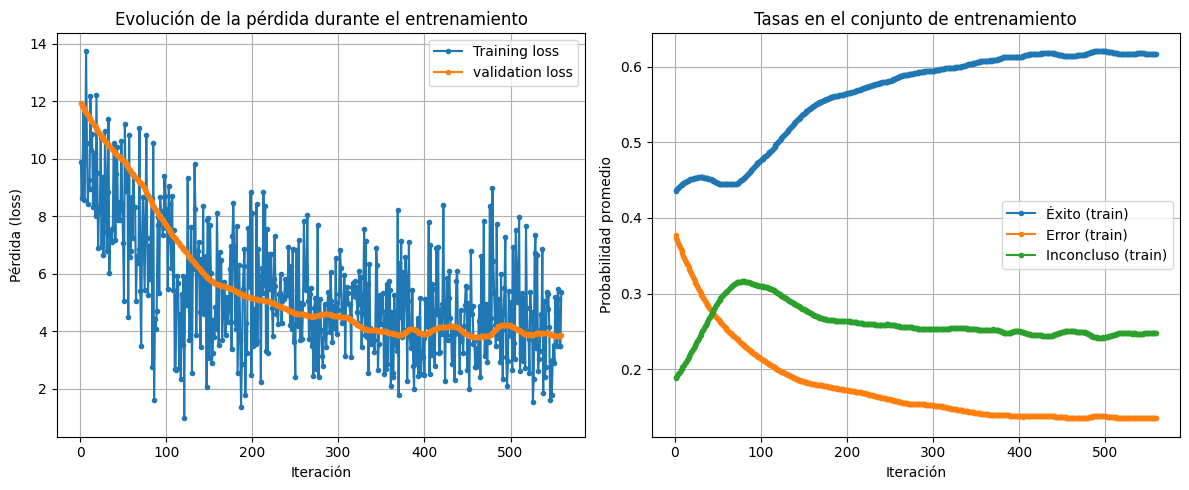

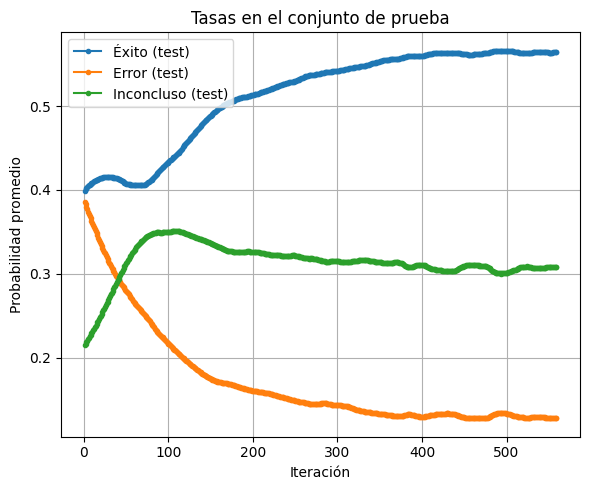

In [13]:
# Visualización de los resultados
plt.figure(figsize=(12,5))

# Evolución de la pérdida
plt.subplot(1,2,1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss")
plt.plot(range(1, it+1), val_loss_history, '.-', label="validation loss")
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la pérdida durante el entrenamiento")
plt.grid()
plt.legend()

# Éxito, Error e Inconcluso en train
plt.subplot(1,2,2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito (train)")
plt.plot(range(1, it+1), train_err_history, '.-', label="Error (train)")
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso (train)")
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas en el conjunto de entrenamiento")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Figura para test
plt.figure(figsize=(6,5))

# Éxito, Error e Inconcluso en test
plt.plot(range(1, it+1), test_suc_history, '.-', label="Éxito (test)")
plt.plot(range(1, it+1), test_err_history, '.-', label="Error (test)")
plt.plot(range(1, it+1), test_inc_history, '.-', label="Inconcluso (test)")
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas en el conjunto de prueba")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

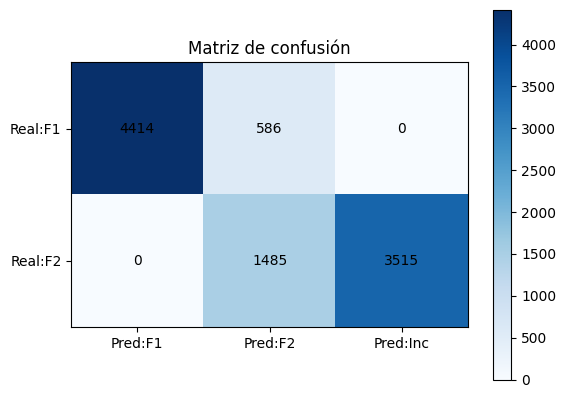

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
